# Decision Tree Model Selection 

In this exercise, you will perform model selection on decision tree classifiers in order to find the best model. You can refer back to your Unit 3 notebooks if you need a refresher on implementing Decision Trees.

* You will train the decision tree models on "cell2cell," a telecom company churn prediction data set.
* You will take the training set and perform model selection to find the value of hyperparameter 'max depth' that results in the best cross-validation accuracy score.
* You will then implement model selection by using built-in cross-validation tools from `sklearn` that will automatically and repeatedly subsample validation sets out of the training set and compute the accuracy when testing on these validation sets. You will use scikit-learn's `GridSearchCV` and `validation_curve` to accomplish this.

**<font color='red'>Note: Some of the code cells in this notebook may take a while to run.</font>**

### Import Packages

Before you get started, import a few packages. Run the code cell below. 

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns


We will also import the scikit-learn `DecisionTreeClassifier`, the `train_test_split()` function for splitting the data into training and test sets, the function `cross_val_score` to perform k-fold cross-validation, and the metric `accuracy_score` to evaluate your model.

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

##  Step 1: Load a 'ready-to-fit' Data Set 

We will work with the "cell2celltrain" data set. This data set is already preprocessed, with the proper formatting, outliers and missing values taken care of, and all numerical columns scaled to the [0, 1] interval. One-hot encoding has been performed on all categorical columns. Run the cell below to load the data set and save it to DataFrame `df`.

In [3]:
filename = os.path.join(os.getcwd(), "data", "cell2celltrain.csv")
df = pd.read_csv(filename, header=0)

## Step 2: Create Training and Test Data Sets

### a. Create Labeled Examples

Let's obtain columns from our data set to create labeled examples. 
In the code cell below, carry out the following steps:

* Get the `Churn` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Assign all other columns from DataFrame `df` to the variable `X`. These will be our features. 


### Graded Cell

The cell below will be graded. Remove the line "raise NotImplementedError()" before writing your code.

In [4]:
y = df['Churn']
X = df.drop(columns = 'Churn', axis=1)

### Self-Check

Run the cell below to test the correctness of your code above before submitting for grading. Do not add code or delete code in the cell.

In [5]:
# Run this self-test cell to check your code; 
# do not add code or delete code in this cell
from jn import testXY

try:
    p, err = testXY(y,X,df)
    print(err)
except Exception as e:
    print("Error!\n" + str(e))
    

Correct!


### b. Split Labeled Examples Into Training and Test Sets

Recall that when performing model selection, we split our data into 3 subsets: training, validation, and test. We train on our training set, evaluate on our validation set, make necessary tweaks to the hyperparameters, and continue this process until we are content with our model's performance. We save our test set for the very last and final evaluation of how well our model generalizes to new data.

In the code cell below, use the `train_test_split()` function to create training and test sets out of the labeled examples. Create a test set that is 10% (.10) of the size of the data set and use a seed value of 1234.

Assign the outputs to the following variable names, using the following order:  `X_train`, `X_test`, `y_train`, `y_test`. 

### Graded Cell

The cell below will be graded. Remove the line "raise NotImplementedError()" before writing your code.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

### Self-Check

Run the cell below to test the correctness of your code above before submitting for grading. Do not add code or delete code in the cell.

In [7]:
# Run this self-test cell to check your code; 
# do not add code or delete code in this cell
from jn import testSplit

try:
    p, err = testSplit(X_train, X_test, y_train, y_test, df)
    print(err)
except Exception as e:
    print("Error!\n" + str(e))
    


Correct!


### c. Inspect the Training and Test Data Sets

In [8]:
print(X_train.shape)
print(X_test.shape)

(45942, 84)
(5105, 84)


In [9]:
X_train.head()

,CustomerID,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,...,Occupation_Crafts,Occupation_Homemaker,Occupation_Other,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student,Married_False,Married_True,Married_nan
45106,3356966,False,False,True,False,False,True,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38896,3310250,True,False,True,False,False,True,True,True,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29853,3237338,False,False,True,False,False,True,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33048,3263222,False,False,True,False,False,True,True,True,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
21061,3165118,False,False,True,False,False,False,False,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Step 3: Perform Decision Tree Model Selection

Our goal is to find the optimal choice of hyperparameter `max_depth` (the maximum depth of the tree). We want to train decision tree models on the training data set, with different values of hyperparameter `max_depth`, and find the model that results in the best cross-validation (CV) score.

The code cell below contains a list of four values for `max_depth`. Run the cell and examine the values.

In [10]:
hyperparams = [2**n for n in range(2,5)]
hyperparams

[4, 8, 16]

In the code cell below, you will use the `max_depth` hyperparameter values contained in list `hyperparams`; you will train three different decision tree classifiers with corresponding `max_depth` values. You will perform a 5-fold cross-validation on each model and obtain the average accuracy score for each of the three models.

In the code cell below, a `for` loop that iterates over the list `hyperparams` has been implemented for you. 
In the loop, do the following:

1. Create a `DecisionTreeClassifier` model object with the following arguments: the parameter `max_depth` being equal to the current `max_depth` value contained in list `hyperparams`, and the parameter `min_samples_leaf` being equal to 1. Assign the model object to variable `model`.
2. Call the scikit-learn `cross_val_score()` function with the following arguments: your model, the training data, and a value of 5 for the number of folds. Assign the result to the variable `acc_score`.
3. Compute the mean of the resulting accuracy scores from the call to  `cross_val_score()` and assign the mean to the variable `acc_mean`.
4. Append the mean to the list `accuracy_scores`.


At the end of the loop, the performance of each model is printed.

<b>Note</b>: This may take a little while to run.


### Graded Cell

The cell below will be graded. Remove the line "raise NotImplementedError()" before writing your code.

In [11]:
print('Running k-fold Cross-Validation...')

accuracy_scores = []

for md in hyperparams:
    
    # 1. Create a DecisionTreeClassifier model object
    # YOUR CODE HERE
    model = DecisionTreeClassifier(max_depth = md, min_samples_leaf=1)
    
    # 2. Perform a k-fold cross-validation for the decision tree
    # YOUR CODE HERE
    acc_score = cross_val_score(model, X_train, y_train, cv = 5)
    
    # 3. Find the mean of the resulting accuracy scores 
    # YOUR CODE HERE
    acc_mean = np.mean(acc_score)
    
    # 4. Append the mean score to the list accuracy_scores
    # YOUR CODE HERE
    accuracy_scores.append(acc_mean)
    
print('Done\n')

for s in range(len(accuracy_scores)):
    print('Accuracy score for max_depth {0}: {1}'.format(hyperparams[s], accuracy_scores[s]))

Running k-fold Cross-Validation...
Done

Accuracy score for max_depth 4: 0.7145966887118208
Accuracy score for max_depth 8: 0.7097427372064221
Accuracy score for max_depth 16: 0.6706935375827688


### Self-Check

Run the cell below to test the correctness of your code above before submitting for grading. Do not add code or delete code in the cell. <b>Note</b>: This may take a little while to run.

In [12]:
# Run this self-test cell to check your code; 
# do not add code or delete code in this cell
from jn import testModelSelection

try:
    p, err = testModelSelection(df, accuracy_scores)
    print(err)
except Exception as e:
    print("Error!\n" + str(e))
    

Running Test.....
Test Complete. See results below:


Correct!


Now that you have found the value of `max_depth` that produces the best model, you can fit a `DecisionTreeClassifier` with that value of `max_depth` on the training data, test your model on the test set (`X_test`), and obtain the final accuracy score of your model's class label predictions.

Complete the code cell below by training a `DecisionTreeClassifier` model object with the value of `max_depth` that resulted in the best accuracy score. Use the `min_samples_leaf` parameter of 1.

### Graded Cell

The cell below will be graded. Remove the line "raise NotImplementedError()" before writing your code.

In [13]:
# 1. Create a DecisionTreeClassifier model object and assign it to the variable 'model'
# YOUR CODE HERE
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 1)
    
# 2. Fit the model to the training data 
# YOUR CODE HERE
model.fit(X_train, y_train) 


# 3. Use the predic() method to make predictions on the test data and assign the results to 
# the variable 'class_label_predictions'
# YOUR CODE HERE
class_label_predictions= model.predict(X_test) 

# 4. Compute the accuracy score and assign the result to the variable 'acc_score'
# YOUR CODE HERE
acc_score = accuracy_score(y_test, class_label_predictions)

print(acc_score)

0.7171400587659158


### Self-Check

Run the cell below to test the correctness of your code above before submitting for grading. Do not add code or delete code in the cell.

In [14]:
# Run this self-test cell to check your code; 
# do not add code or delete code in this cell
from jn import testDTModel

try:
    p, err = testDTModel(df, model,class_label_predictions, acc_score)
    print(err)
except Exception as e:
    print("Error!\n" + str(e))
    

Correct!


## Step 4: Model Selection Using a Validation Curve

There are multiple functions in `sklearn` that implement some version of model selection in which they search over different combinations of possible hyperparameter values to find the set that results in the best cross-validation (CV) score.

Some of these functions return the validation scores only, some other ones return both the validation and the training set performance (how well the model fits to the data it was trained on), and others have useful attributes where you can retrieve the value of the best-scoring hyperparameter with a simple command. Let's review one of these: the scikit-learn `validation_curve()` function. What you just implemented above can be performed by the `validation_curve()` function in scikit-learn. 

For more information, consult the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html).

Let's first import the function.


In [15]:
from sklearn.model_selection import validation_curve

The code cell below uses the `validation_curve()` function to train three decision tree models with different values for the `max_depth` hyperparameter (same values as above). It performs cross-validation on each model. It returns the training and validation accuracy scores for each k-fold cross-validation performed.

The function expects the following inputs: a model object, the training data, the name of the hyperparameter (in this case, `max_depth`), a range of hyperparameter values, and the number of cross-validation folds (k). Note that for a classifier, the function `cross_val_score()` uses the scikit-learn `accuracy_score` metric by default. 

Examine the code and run the cells below to inspect the output. <b>Note</b>: This may take a little while to run.


In [16]:
print('Running Validation Curve Implementation...')

# Create a DecisionTreeClassifier model object without supplying arguments
model = DecisionTreeClassifier()

# Create a range of hyperparameter values for 'max_depth'. Note these are the same values as those we used above
hyperparams = [2**n for n in range(2,5)]

# Call the validation_curve() function with the appropriate parameters
training_scores, validation_scores = validation_curve(model, X_train, y_train,
                                       param_name = "max_depth",
                                       param_range = hyperparams,
                                        cv = 5)

print('Done\n')

print(validation_scores)


Running Validation Curve Implementation...
Done

[[0.71400588 0.7141147  0.7152808  0.71538964 0.71419242]
 [0.71095876 0.70682338 0.70711798 0.71016543 0.71201567]
 [0.66514311 0.66971379 0.66097083 0.67098389 0.67718764]]


The cell below outputs the result of 5-fold cross-validation for the different hyperparameter values of `max_depth`. The `max_depth` resulting in the best cross-validation score should match your implementation above.

In [17]:
mean_validation_scores = np.mean(validation_scores, axis = 1)
for h in range(0, len(hyperparams)):
    print('Results of cross-validation for max_depth of {0}: {1}'.format(hyperparams[h], mean_validation_scores[h]))
    

Results of cross-validation for max_depth of 4: 0.7145966887118208
Results of cross-validation for max_depth of 8: 0.7094162433145231
Results of cross-validation for max_depth of 16: 0.6687998507424007


The code cell below plots the validation curve, with the values of the parameter `max_depth` on the $x$-axis, and the accuracy scores on the validation set on the $y$-axis.

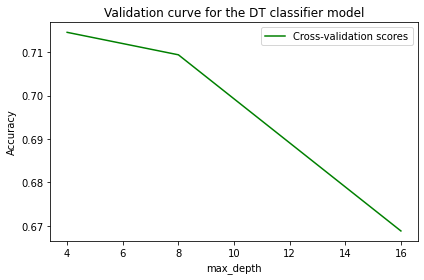

In [18]:
sns.lineplot(x=hyperparams, y=mean_validation_scores, label = "Cross-validation scores", color = 'g')

plt.title("Validation curve for the DT classifier model")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')

plt.show()

# Step 5: Model Selection Using Grid Search Cross-Validation

The function `validation_curve()` finds the best value for one hyperparameter. What if you want to find the best combination of hyperparameter values for more than one hyperparameter?

Scikit-learn has a class named `GridSearchCV` that allows you to search over different combinations of possible hyperparameter values to find the set that results in the best cross-validation (CV) score. It accomplishes what you implemented in one line of code.

It enables us to find the best-performing combination of values for several hyperparameters. You can find the names of the `DecisionTreeClassifier` hyperparameters in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You can also find more information on `GridSearchCV` in the corresponding [scikit-learn documentaton](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Note that for a classifier, `GridSearchCV` uses the scikit-learn `accuracy_score` metric by default. Also note that there are different ways to specify the number of folds using the parameter `cv`. You can supply it the output of scikit-learn's `KFolds`, but for simplicity, in this unit's exercises we will ask you to supply an integer value.

Our objective is to determine the optimal choice for two hyperparameters when fitting a decision model to our training data: the maximum depth of the tree (`max_depth`) and the minimum number of samples required to be at a leaf node (`min_samples_leaf`). We will run a grid search over the set of possible parameter value pairs, computing the accuracy score each time. These scores should help us decide on the optimal values of the two parameters.


###  a. Set Up the Parameter Grid

`GridSearchCV` requires a *parameter grid* as an input. This contains the hyperparameter names and their possible values. A *parameter grid* is typically stored as a Python dictionary. Each key/value pair in the dictionary is the name of the hyperparameter and a Python list of possible values.


Note: It is important that the key is spelled exactly the same way as the the scikit-learn model class expects its parameters to be spelled. In our case, the `sklearn` function `DecisionTreeClassifier` expects 'max_depth' and 'min_samples_leaf', so be sure to use these spellings as the keys in your dictionary.

The code cell below creates a dictionary containing parameter names and lists of their possible values to search over. <br>
For `max_depth`, the values are the same as above: four consecutive powers of two. <br>
For `min_samples_leaf`, the values are 25, 50, 100.

In [19]:
# Create a range of hyperparameter values for 'max_depth'. 
#Note these are the same values as those we used above
hyperparams_depth = [2**n for n in range(2,5)]

# Create a range of hyperparameter values for 'min_samples_leaf'. 
hyperparams_leaf = [25*2**n for n in range(0,3)]

# Create parameter grid.
param_grid={'max_depth':hyperparams_depth, 'min_samples_leaf':hyperparams_leaf}
param_grid

{'max_depth': [4, 8, 16], 'min_samples_leaf': [25, 50, 100]}

### b. Perform Grid Search Cross-Validation
First, lets import `GridSearchCV`:

In [20]:
from sklearn.model_selection import GridSearchCV

In the code cell below, use `GridSearchCV` to find the hyperparameters `max_depth` and `min_samples_leaf`  that result in the best model.

Follow the following steps:

1. Create a `DecisionTreeClassifier` model object without any arguments. Assign the model object to the variable `model`.

2. Call `GridSearchCV()` and assign the result to the object `grid`. Call `GridSearchCV()` with the following arguments:
    1. Your decision tree model object `model`.
    2. The parameter grid `param_grid` that was created above.
    3. Use the parameter `cv` and specify that the number of folds is 5 (`cv=5`).

3. Call ```grid.fit()```. The first argument should be ```X_train``` and the second argument should be ```y_train```. Save the result to the variable `grid_search`.

<b>Note</b>: This may take a little while to run.


### Graded Cell

The cell below will be graded. Remove the line "raise NotImplementedError()" before writing your code.

In [21]:
print('Running Grid Search...')

# 1. Create a DecisionTreeClassifier model object without supplying arguemnts
# YOUR CODE HERE
model = DecisionTreeClassifier()
# 2. Run a Grid Search with 5-fold cross-validation using the model.
#   Pass all relevant parameters to GridSearchCV and assign the output to the object 'grid'
# YOUR CODE HERE
grid = GridSearchCV(model, param_grid, cv = 5)


# 3. Fit the model on the training data and assign the fitted model to the 
#    variable grid_search
# YOUR CODE HERE
grid_search = grid.fit(X_train,y_train)

print('Done')

Running Grid Search...
Done


### Self-Check

Run the cell below to test the correctness of your code above before submitting for grading. Do not add code or delete code in the cell. <b>Note</b>: This may take a few minutes to run.

In [22]:
# Run this self-test cell to check your code; 
# do not add code or delete code in this cell
from jn import testGridSearch

try:
    p, err = testGridSearch(model, grid, grid_search)
    print(err)
except Exception as e:
    print("Error!\n" + str(e))
    

Correct!


### c. Identify the Best Hyperparameter Values

The fitted model object `grid_search` has built-in attributes that you can access to examine the results.

In [23]:
# Print best-performing hyperparameter configuration
print('Optimal hyperparameters: {0}'.format(grid_search.best_params_))

# print best accuracy score resulting from this configuration
print('Accuracy score: {0}'.format(grid_search.best_score_))

Optimal hyperparameters: {'max_depth': 4, 'min_samples_leaf': 50}
Accuracy score: 0.7147490424208727


Notice that all three model selection techniques returned the same optimal value of `max_depth`.